In [ ]:
# Write data to folder in google drive
# IMPRINT_DIR = os.path.join(ROOT_DIR, 'combined_dataset', 'imprint_dataset')
COLOUR_DIR = os.path.join(ROOT_DIR, 'combined_dataset', 'colour_dataset')
CANNY_DIR = os.path.join(ROOT_DIR, 'combined_dataset', 'canny_dataset')
TEXTURE_DIR = os.path.join(ROOT_DIR, 'combined_dataset', 'texture_dataset')

## 1. Colour

First experimentation involved image preprocessing and obtaining region-based colour histograms as features.

Region-based colour histograms is a common technique seen in CBIR. In the space of deep learning however, neural networks have the ability to extract high-level features and having images in RGB colour space as inputs to pre-trained models may suffice. The CNN model is likely inclined to learn that certain colours are decisive features as pills of each class contain dominant RGB values that represent colour attributes.

In comparison to MobileDeepNet's approach of having both colour and greyscale image streams, this implementation adopts a single colour space stream as consumer images were taken in natural scenes unlike the grey background of reference images taken under controlled lighting conditions. It is also essential to note that background subtraction on consumer images was not carried out, considering the utilisation of ImageNet to recognise objects in real-world scenes, where colour plays a semantic role.

Hence, the final implementation of feature engineering for the coloured image stream consists of image preprocessing techniques:
- Guassian blur to reduce color inconsistencies and imprints
- Bilateral filter to smoothen images while still retaining sharp edges
- Aadaptive histogram equalisation through LAB colour space (apply clahe on L-channel) for local contrast enhancement --> may aid illumination variations (--> illumination normalisation)

In [ ]:
class ColourPreprocessor(object):
  """
  Preproccesses orginal dataset of images for shape extraction
  """
  def __init__(self, apply_clahe=True, bins=(4, 8, 12), target_size=224, clip_limit=3.0, tile_grid_size=(5, 5)):

    # Initialise and assign variables
    self.target_size = target_size
    self.clip_limit = clip_limit
    self.tile_grid_size = tile_grid_size
    self.apply_clahe = apply_clahe

    self.bins = bins

    self.k_clusters = 2
    self.alpha = False

  def image_generator(self, img):
    try:
      # Preprocess image
      pp_img = self.preprocess_image(img)

      return pp_img

    except Exception as e:
      print("[Image generator] Error occured:\n", e)

  def data_generator(self, img):
    try:
      # Preprocess image
      pp_img = self.preprocess_image(img)

      # Get colour histogram features
      colour_features = self.get_colour_hist(pp_img)

      return colour_features

    except Exception as e:
      print("[Colour extraction] Error occured:\n", e)

  def preprocess_image(self, img ):
    """
    Image preprocessing to get more accurate colours
    """
    try:
      # Apply blurring to reduce color inconsistencies and imprints
      img = cv2.GaussianBlur(img, (3, 3), 0)

      if self.apply_clahe:
        # Apply histogram equalisation on v channel of hsv image
        img = self.hist_equalisation(img)

      return img

    except Exception as e:
      print("[Image Preprocessing] Error occured:\n", e)

  def hist_equalisation(self, img):
    """
    Function that applies histogram equalisation technique to L channel of LAB image
    """
    # Convert image to LAB
    lab_img  = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # split the image into L, A, B channels
    l_channel, a_channel, b_channel = cv2.split(lab_img)

    # Apply filter to reduce noise
    lab_img = cv2.bilateralFilter(lab_img, 7 , 11, 11)

    # Apply histogram equalisation technique on lightness (L) channel
    clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
    clahed_l = clahe.apply(l_channel)

    # Merge clahed_l with the remaining untouched A, B channels
    merged_channels = cv2.merge((clahed_l, a_channel, b_channel))

    # Convert back to BGR image
    final_output = cv2.cvtColor(merged_channels, cv2.COLOR_LAB2BGR)
    return final_output

  # source: https://stackoverflow.com/questions/14134892/convert-image-from-pil-to-opencv-format
  def pil_to_cv2(self, pil_image):
      cv2_image = np.array(pil_image)
      cv2_image = cv2_image[:, :, ::-1].copy()
      return cv2_image

  def cv2_to_pil(self, cv2_image):
      return PIL.Image.fromarray(cv2_image)

  # source: https://github.com/sherlockchou86/cbir-image-search/blob/master/cbir_ch_feature.py#L61
  # source: https://github.com/pochih/CBIR/tree/master
  def get_colour_hist(self, img):
    colour_features = []

    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Obtain dimensions of image
    height, width = hsv_img.shape[:2]
    # Obtain center coordinates of image
    x_center = int(width / 2)
    y_center = int(height / 2)

    # divide the image into four rectangles/segments (top-left,
    # top-right, bottom-right, bottom-left)
    segments = [(0, x_center, 0, y_center),
     (x_center, width, 0, y_center),
      (x_center, width, y_center, height),
      (0, x_center, y_center, height)]

    # construct an elliptical mask representing the center of the image
    x_axes = int(width * 0.75) // 2
    y_axes = int(height * 0.75) // 2
    ellipse_mask = np.zeros(hsv_img.shape[:2], dtype=np.uint8)
    cv2.ellipse(ellipse_mask, (x_center, y_center), (x_axes, y_axes), 0, 0, 360, 255, -1)

    # loop over the segments
    for x_start, x_end, y_start, y_end in segments:
        # construct a mask for each corner of the image, subtracting
        # the elliptical center from it
        corner_mask = np.zeros(hsv_img.shape[:2], dtype = "uint8")
        cv2.rectangle(corner_mask, (x_start, y_start), (x_end, y_end), 255, -1)
        corner_mask = cv2.subtract(corner_mask, ellipse_mask)

        # extract a color histogram from the image, then update the feature vector
        histgm = self.get_histogram(hsv_img, corner_mask, self.bins)
        colour_features.extend(histgm)

    # extract a color histogram from the elliptical region and update the feature vector
    histgm = self.get_histogram(hsv_img, ellipse_mask, self.bins)
    colour_features.extend(histgm)

    # return the feature vector
    # the vector contains 4 corner regions and 1 center region, 5 parts totally
    # the dimension equals bins[0]*bins[1]*bins[2]*5
    return colour_features

  def get_histogram(self, img, mask, bins):
    # extract a 3D color histogram from the masked region of the image,
    # using the supplied number of bins per channel
    histgm = cv2.calcHist([img], [0, 1, 2], mask, bins, [0, 180, 0, 256, 0, 256])

    # Return normalised histogram
    return cv2.normalize(histgm, histgm).flatten()

In [ ]:
def colour_preprocessing_pipeline(image_paths,
                                 is_float=True,
                                 apply_clahe=True, image_size=IMAGE_SIZE,
                                 clip_limit=3.0, tile_grid_size=(5, 5)):

  #Instantiate class instances
  colour_preprocessor = ColourPreprocessor(target_size=image_size,
                                           clip_limit=clip_limit,
                                           tile_grid_size=tile_grid_size)

  # Store preprocessed data
  X = []

  # Apply functions on each image
  for image_path in tqdm(image_paths):
    # Read image
    input_img = cv2.imread(image_path)
    # Preprocess image
    img = colour_preprocessor.image_generator(input_img)

    # Append data to respective lists
    X.append(img)

  # Return preprocessed data
  if is_float:
    return np.array(X, np.float32)
  return np.array(X)

In [ ]:
# Preprocess train and val sets
X_train_colour_image = colour_preprocessing_pipeline(image_paths=X_train)
X_val_colour_image = colour_preprocessing_pipeline(image_paths=X_val)

400it [00:07, 56.86it/s]
100it [00:01, 60.92it/s]


In [ ]:
def create_folder(file_path):
  try:
    os.makedirs(file_path)
  except FileExistsError:
    print('Folder exists')

def save_image_to_dir(image_array, og_filepaths, destination_dir):
  filepath_label = {
      'original_filepath': [],
      'filepath': []
  }

  try:
    for image, og_filepath in tqdm(zip(image_array, og_filepaths)):
      class_name = og_filepath.split('/')[-2] # class --> ndc9

      try:
        classed = os.path.join(destination_dir, class_name)
        os.mkdir(classed)
      except:
        print('Folder exists')

      filename = og_filepath.split('/')[-1] # Get filename
      destination = os.path.join(classed, filename)  # /content/__dataset/class_name/filename

      if not os.path.isfile(destination):
        cv2.imwrite(destination, image)

        filepath_label['original_filepath'].append(og_filepath)
        filepath_label['filepath'].append(destination)

      else:
        print('File exists: {}'.format(filename))

  except Exception as e:
    print(f'Error occured for {filename}: {e}')

  return pd.DataFrame(filepath_label)

  print("SAVING COMPLETED!")

In [ ]:
# create_folder(COLOUR_DIR)

# X_colour_train_df = save_image_to_dir(X_train_colour_image, X_train, COLOUR_DIR)
# X_colour_val_df = save_image_to_dir(X_val_colour_image, X_val, COLOUR_DIR)

In [ ]:
# X_colour_train_df.to_csv(str(os.path.join(ROOT_DIR, 'combined_dataset', "Train_colour_directory.csv")))
# X_colour_val_df.to_csv(str(os.path.join(ROOT_DIR, 'combined_dataset', "Val_colour_directory.csv")))

In [ ]:
# # Save to .npz for usage in other sessions
# np.savez(os.path.join(NPZ_DIR, 'Train_colours.npz'), filename=X_train, image=X_train_colour_image)
# np.savez(os.path.join(NPZ_DIR, 'Val_colours.npz'), filename=X_val, image=X_val_colour_image)

In [ ]:
def to_array(x):
  return np.array(literal_eval(re.sub('\s+', ',', x)))

In [ ]:
train_df = pd.read_csv(os.path.join(ROOT_DIR, 'combined_dataset', "Train_colour_directory.csv"), index_col=0)
train_df = pd.merge(data_df[['filepath', 'ndc9']], train_df, left_on="filepath",
                                right_on="original_filepath", how='inner').drop(columns=["filepath_x"]).rename(columns={
                                    'filepath_y': 'colour_filepath'
                                })

val_df = pd.read_csv(os.path.join(ROOT_DIR, 'combined_dataset', "Val_colour_directory.csv"), index_col=0)

val_df = pd.merge(data_df[['filepath', 'ndc9']], val_df, left_on="filepath",
                                right_on="original_filepath", how='inner').drop(columns=["filepath_x"]).rename(columns={
                                    'filepath_y': 'colour_filepath'
                                })

In [ ]:
test_df = pd.DataFrame({
    "original_filepath": X_test})

test_df = pd.merge(data_df[data_df["filepath"].isin(X_test)][['filepath', 'ndc9']], test_df, left_on="filepath",
                                right_on="original_filepath", how='inner').drop(columns=["filepath"])

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ndc9               400 non-null    object
 1   original_filepath  400 non-null    object
 2   colour_filepath    400 non-null    object
 3   histogram          400 non-null    object
 4   label              400 non-null    object
dtypes: object(5)
memory usage: 18.8+ KB


In [ ]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ndc9               100 non-null    object
 1   original_filepath  100 non-null    object
 2   colour_filepath    100 non-null    object
 3   histogram          100 non-null    object
 4   label              100 non-null    object
dtypes: object(5)
memory usage: 4.7+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 0 to 55
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ndc9               56 non-null     object
 1   original_filepath  56 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB


Visualise colour-preprocessed sample

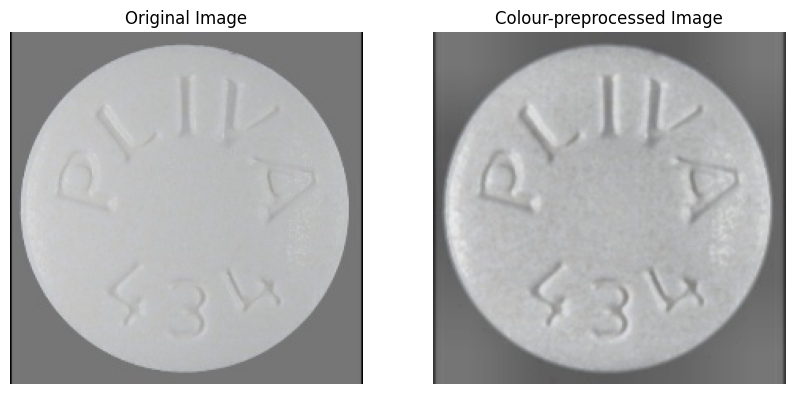

In [ ]:
# Show original image
img_sample = PIL.Image.open(train_df['original_filepath'].values[10])
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title(f'Original Image')
plt.imshow(img_sample)
plt.axis('off')

# Show preprocessed mage
pp_sample = PIL.Image.open(train_df['colour_filepath'].values[10])
plt.subplot(1, 2, 2)
plt.title(f'Colour-preprocessed Image')
plt.imshow(pp_sample)
plt.axis('off')

# Show Result
plt.show()

importance of colour:
- https://www2.cs.sfu.ca/~funt/Funt_Zhu_DoesColourMatter_CIC26_2018.pdf

- https://stackoverflow.com/questions/65828713/the-role-effect-of-color-information-on-cnn

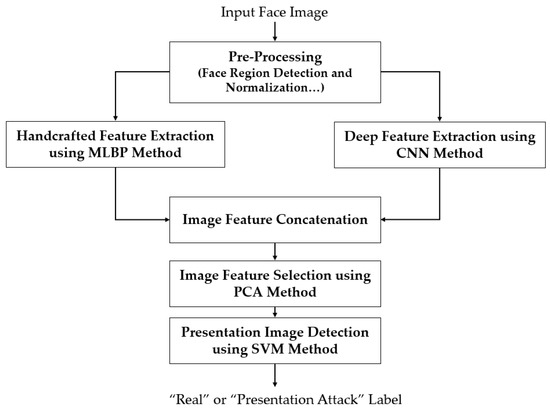

source: https://www.mdpi.com/1424-8220/18/3/699

## 2. Shape: Canny Edge vs. Contours

Shared preprocessing steps before detection or extraction:
- Noise removal from previously colour-preprocessed image with OpenCV's fastNlMeansDenoisingColored
- Downsample greyscale image
- Remove black borders surrounding cropped images
- Contrast enhancement for images with low contrast such as images with white pills on grey background



(i) Canny Edge Detection is a multi-stage algorithm that undergoes:
1. Noise Reduction
2. Computation of iamge intensity gradient
3. Non-maximum Supression
4. Hysteresis Thresholding

The Canny algorithm here integrated Otsu thresholding to compute a range of values for the upper and lower thresholds of canny edge detection at step 4. The final output is a binarised image with white-lined edges and a black background.


source: https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html



(ii) Contour dectection through convex hull performs multiple steps, where the combination of hulls served as an additional step to form to find the best representation of a shape object:
1. Thresholding for image binarisation
2. Find contours to get a list of boundary points around each blob
3. Find nearby coordinates and combine one or more convex hulls
4. Draw covex hull and fill inner area

This enhanced method produces a binarised image, where white occupies the detected shape area and black as the background.

source: https://learnopencv.com/convex-hull-using-opencv-in-python-and-c/


In [ ]:
def compare_images(array_1, array_2,
                   idx=None, is_rgb=True,
                   new_cmap='gray',
                   new_title='Transformed Image'):
  if idx == None:
    idx = random.randint(0, len(array_2)) if len(array_2) > array_1 else random.randint(0, len(array_1))

  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  if is_rgb:
    ax[0].imshow(cv2.cvtColor(cv2.imread(array_1[idx]), cv2.COLOR_BGR2RGB))
  else:
    ax[0].imshow(cv2.imread(array_1[idx]))
  ax[0].set_title("Original Image")
  ax[1].imshow(array_2[idx], cmap=new_cmap)
  ax[1].set_title(new_title)
  plt.show()

In [ ]:
class ShapeExtractor(object):
  """
  Preproccesses colour-enhanced dataset for shape extraction
  """

  def __init__(self, ext_method, target_size=224):
    """
    ext_method = [1, 2]
    --> 1: Method involving contours and convexHull
    --> 2: Method involving canny edge detection
    """

    # Initialise and assign variables
    self.target_size = target_size
    self.ext_method = ext_method
    self.dist_thresh = 48

  def image_generator(self, img):
    """
    Generates preprocessed images
    """
    try:
      # Preprocess image
      pp_img = self.preprocess_image(img)

      if self.ext_method == 1:
        # Form shapes by extracting largest contour area
        final_img = self.contour_method(pp_img)

      elif self.ext_method == 2:
        final_img = self.apply_canny(pp_img)

      # Resize masked image back to original size
      final_img = self.resize_img(final_img)

      return final_img

    except Exception as e:
      print("[Shape extraction] Error occured:\n", e)

  def apply_canny(self, grey_img):
    # Apply blurring filter on image
    grey_img = cv2.medianBlur(grey_img, 3)

    # source: https://stackoverflow.com/questions/46031923/how-to-save-opencv-image-with-contour
    h, w = grey_img.shape[:2]
    # Get thresholds
    otsu_thresh, _ = cv2.threshold(grey_img, 50, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Compute canny range
    lower, upper = self.get_canny_range(otsu_thresh)
    # Apply canny edge detection
    canny_img = cv2.Canny(grey_img, lower, upper, apertureSize=3)

    # Apply morphological techniques
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilation = cv2.dilate(canny_img, kernel, iterations=1)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opening = cv2.morphologyEx(dilation, cv2.MORPH_OPEN, kernel, iterations=1)

    return opening

  def get_canny_range(self, threshold):
    """
    Computes range of values for upper and lower thresholds of canny edge detection
    """
    sigma = 0.33
    return (1-sigma) * threshold, (1+sigma) * threshold

  def contour_method(self, img):
    """
    Adopts contour method for shape extraction with thresholding, contour-search,
    and combining convex hull to form polygons
    """
    # source: https://stackoverflow.com/questions/52197918/how-to-obtain-combined-convex-hull-of-multiple-separate-shapes
    # Find threshold and contours to formulate shape
    thresh = cv2.threshold(img , 100, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Differentiate contours from hierarchy
    contours = contours[0] if len(contours) == 2 else contours[1]

    combined_hulls = self.get_combined_hulls(contours)

    # Create binary mask of image size
    mask = np.zeros_like(img, dtype=np.uint8)
    # Draw contours on mask
    cv2.drawContours(mask, combined_hulls, -1, 255, cv2.FILLED)
    # Smoothen outermost lines
    final_img = cv2.medianBlur(mask, 1)

    return final_img

  def get_combined_hulls(self, contours):
    """
    Conbines coordinates to draw polygons
    """
    num_contours = len(contours)
    status = np.zeros((num_contours, 1))

    # Find nearby contours to connect vector points for shape formulation
    for i, cnt_a in enumerate(contours):
      x = i
      if i != num_contours - 1:
        for j, cnt_b in enumerate(contours[i+1:]):
          x = x + 1
          dist = self.find_nearby_contour(cnt_a, cnt_b, self.dist_thresh)

          if dist == True:
            val = min(status[i], status[x])
            status[x] = status[i] = val
          else:
            if status[x]==status[i]:
                status[x] = i + 1

    # Combine separate detected shapes to form a single one
    combined_hulls = []
    max_stats = int(status.max()) + 1
    for i in range(max_stats):
      cnt_pos = np.where(status == i)[0]
      if cnt_pos.size != 0:
        # Concatenate points from all shapes into one array
        cnt = np.vstack([contours[i] for i in cnt_pos])
        hull = cv2.convexHull(cnt)
        combined_hulls.append(hull)

    return combined_hulls

  def find_nearby_contour(self, cnt_a, cnt_b, dist_thresh):
    """
    Searches for and filters out irrelevant contours to refine shape extraction
    """
    row_a, row_b = cnt_a.shape[0], cnt_b.shape[0]
    for i in range(row_a):
      for j in range(row_b):
        # Compute euclidean distance
        dist = np.linalg.norm(cnt_a[i] - cnt_b[j])
        if abs(dist) < dist_thresh:
          return True
        elif i==row_a-1 and j==row_b-1:
          return False

  def check_cropped(self, grey_img, margin):
    """
    Function that checks whether image was cropped and returns:
    - Boolean whether image was cropped
    - Coordinates to crop
    """
    is_cropped = False

    # threshold
    thresh = cv2.threshold(grey_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    hh, ww = thresh.shape

    # make bottom 2 rows black where they are white the full width of the image
    thresh[hh-3:hh, 0:ww] = 0

    # get bounds of white pixels
    white = np.where(thresh==255)
    xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])

    og_h, og_w = grey_img.shape[:2]
    # Determine if image was cropped through distance thresholds
    if (xmax - xmin + margin) < og_w or (ymax - ymin + margin) < og_h:
      is_cropped = True
    return is_cropped, (xmin, ymin, xmax, ymax)

  def remove_image_borders(self, grey_img):
    """
    Remove black borders if image was cropped
    """
    try:
      # Convert to grayscale
      # grey_img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
      # Get image dimensions without black borders
      (x_min, y_min, x_max, y_max) = self.check_cropped(grey_img, 35*0.5)[1]

      # Crop grey image to ROI without black borders
      final_img = grey_img[y_min:y_max, x_min:x_max]

      return final_img

    except Exception as e:
      print("[Border Removal] Error occured:\n", e)


  def resize_img(self, img):
    """
    Resize image to target size
    """
    # source: https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/

    # (h, w) of original image
    og_size = img.shape[:2]
    # Find ratio to prevent distortion
    ratio = float(self.target_size)/max(og_size)
    # Ratio-ed (h, w) of desired size
    new_size = tuple([int(x*ratio) for x in og_size])
    # (w, h) of target resized image
    img = cv2.resize(img, (new_size[1], new_size[0]))
    # Find differences of desired size (512) and newly computed size
    delta_w = self.target_size - new_size[1]
    delta_h = self.target_size - new_size[0]
    # Compute values for image padding to make black borders
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    # Generate final binary image according to target size
    final_img = cv2.copyMakeBorder(img, top, bottom, left, right,
                                  cv2.BORDER_CONSTANT,
                                  value=[0, 0, 0])

    return final_img

  def preprocess_image(self, img):
    """
    Image preprocessing for feature refinement on image
    """
    try:
      # Make sure all images have the same size
      img = self.resize_img(img)

      # Remove noise from image
      denoised = cv2.fastNlMeansDenoisingColored(img, None, 17, 17, 7, 21)
      # Convert image to greyscale
      grey_img = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)

      # Downsample image while retaining alpha channel
      downsampled = cv2.pyrDown(grey_img)

      # Get ROI in greyscale
      grey_img = self.remove_image_borders(downsampled.copy())

      # Normlisation if grey image has low contrast
      if is_low_contrast(grey_img, fraction_threshold=0.3):
        # Contrast Enhancement
        grey_img = np.uint8(cv2.normalize(grey_img, grey_img, 0, 255, cv2.NORM_MINMAX))

      return grey_img

    except Exception as e:
      print("[Image Preprocessing] Error occured:\n", e)

In [ ]:
def shape_preprocessing_pipeline(image_paths,
                                 ext_method,
                                 image_size=IMAGE_SIZE):

  #Instantiate class instance
  shape_extractor = ShapeExtractor(target_size=image_size, ext_method=ext_method)

  # Store preprocessed data
  X_images = []

  # Apply functions on each image and assign respective labels
  for image_path in tqdm(image_paths):
    # Read image
    input_img = cv2.imread(image_path)
    # Preprocess image
    img = shape_extractor.image_generator(input_img)

    # Append data to respective lists
    X_images.append(img)

  # Return preprocessed set of data
  return np.array(X_images)

In [ ]:
# Preprocess images for edge feature
contour_shape_image_sample = shape_preprocessing_pipeline(image_paths=np.asarray(train_df['colour_filepath'].values[:5]),
                                                                  ext_method=1)

canny_shape_image_sample = shape_preprocessing_pipeline(image_paths=np.asarray(train_df['colour_filepath'].values[:5]),
                                                                  ext_method=2)

5it [00:00,  6.48it/s]
5it [00:00,  6.49it/s]


Method 1: Contours and convelHull

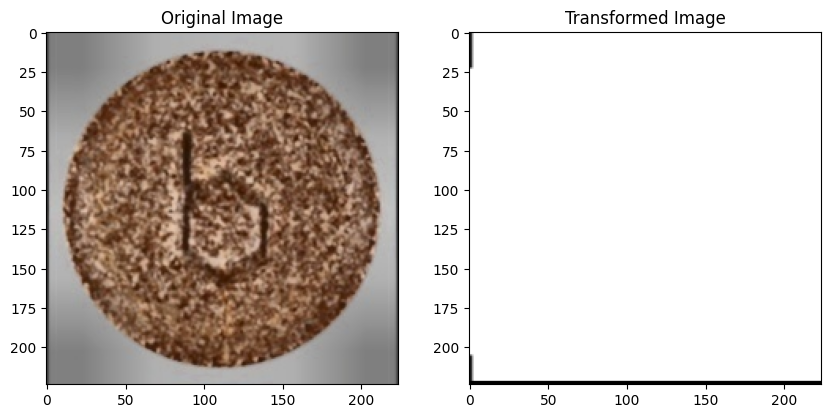

In [ ]:
compare_images(train_df['colour_filepath'].values,
               contour_shape_image_sample,
               idx=1)

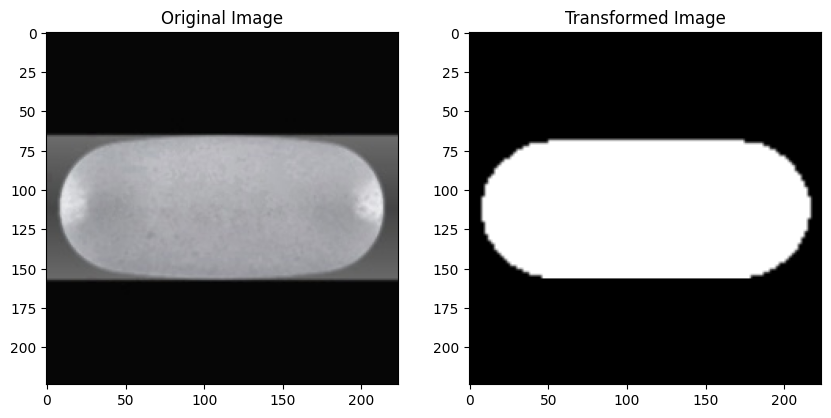

In [ ]:
compare_images(train_df['colour_filepath'].values,
               contour_shape_image_sample,
               idx=2)

Method 2: Canny

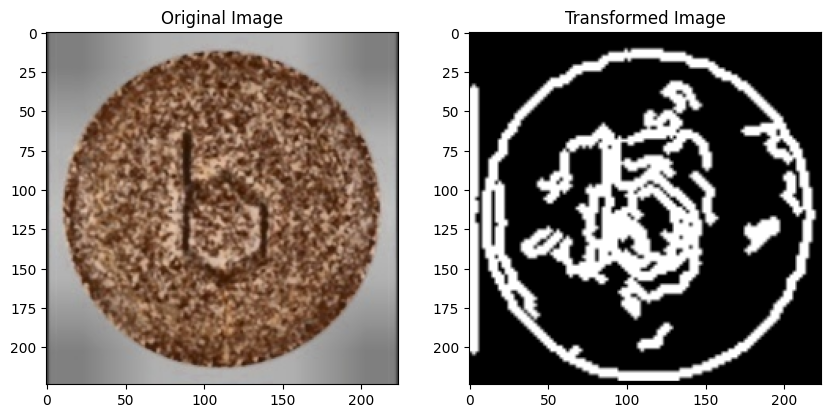

In [ ]:
compare_images(train_df['colour_filepath'].values,
               canny_shape_image_sample,
               idx=1)

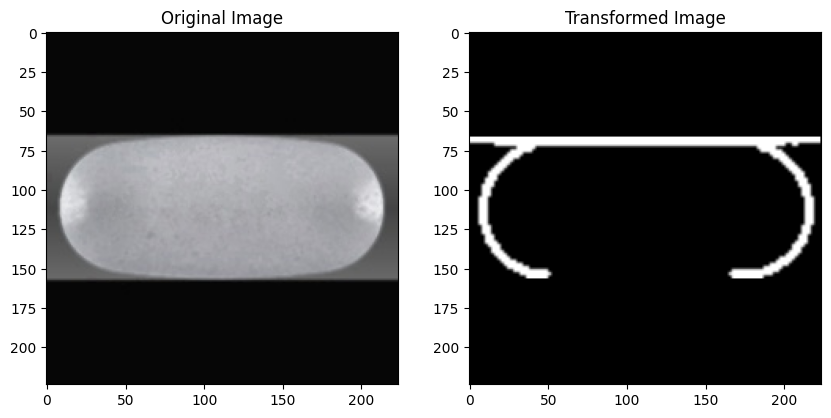

In [ ]:
compare_images(train_df['colour_filepath'].values,
               canny_shape_image_sample,
               idx=2)

Canny Edges vs. Contours

Based on the visualisations, the contour method performed better on images with minimal noise or colour variations with clear lines of edges. By observation, the first pill sample contained drastically more noise and variation in illumination than the second sample. The final result from the contour method was unable to show a definite shape compared to the canny and had a tendency to give blobs that occupied the entirety of some images rather than pill regions. Despite a well-refined and connected shape produced from the contours of the second same, canny edge detection gave a better consistency in providing adequately-formed edge lines in different pills.

Therefore, the final implementation for shape features favoured the Canny edge detection technique.

In [ ]:
def save_image_to_dir(image_array, og_filepaths, destination_dir):
  filepath_dict = {
      'original_filepath': [],
      'filepath': []
  }

  try:
    for image, label, og_filepath in tqdm(zip(image_array, og_filepaths)):
      class_name = og_filepath.split('/')[-2] # class --> ndc9

      try:
        classed = os.path.join(destination_dir, class_name)
        os.mkdir(classed)
      except:
        print('Folder exists')

      filename = og_filepath.split('/')[-1] # Get filename
      destination = os.path.join(classed, filename)  # /content/_dataset/class_name/filename

      if not os.path.isfile(destination):
        cv2.imwrite(destination, image)

        filepath_dict['original_filepath'].append(og_filepath)
        filepath_dict['filepath'].append(destination)

      else:
        print('File exists: {}'.format(filename))

  except Exception as e:
    print(f'Error occured for {filename}: {e}')

  return pd.DataFrame(filepath_dict)

  print("SAVING COMPLETED!")

In [ ]:
# Preprocess train and val sets
X_train_canny_image = shape_preprocessing_pipeline(image_paths=np.asarray(train_df['colour_filepath'].values),
                                                                  ext_method=2)
X_val_canny_image = shape_preprocessing_pipeline(image_paths=np.asarray(val_df['colour_filepath'].values),
                                                              ext_method=2)

400it [01:08,  5.88it/s]
100it [00:15,  6.56it/s]


In [ ]:
# create_folder(CANNY_DIR)

# X_canny_train_df = save_image_to_dir(X_train_canny_image, X_train, CANNY_DIR)
# X_canny_val_df = save_image_to_dir(X_val_canny_image, X_val, CANNY_DIR)

In [ ]:
# Save to .npz for re-usage
np.savez(os.path.join(NPZ_DIR, 'Train_canny.npz'), filename=X_train, image=X_train_canny_image)
np.savez(os.path.join(NPZ_DIR, 'Val_canny.npz'), filename=X_val, image=X_val_canny_image)

In [ ]:
# X_canny_train_df.to_csv(str(os.path.join(ROOT_DIR, 'combined_dataset', "Train_canny_directory.csv")))
# X_canny_val_df.to_csv(str(os.path.join(ROOT_DIR, 'combined_dataset', "Val_canny_directory.csv")))

X_canny_train_df = pd.read_csv(str(os.path.join(ROOT_DIR, 'combined_dataset', "Train_canny_directory.csv")),
                               index_col=0)
X_canny_val_df = pd.read_csv(str(os.path.join(ROOT_DIR, 'combined_dataset', "Val_canny_directory.csv")),
                               index_col=0)

In [ ]:
train_df = pd.merge(train_df, X_canny_train_df, left_on="original_filepath",
                                right_on="original_filepath", how='inner').drop(columns=["label_y"]).rename(columns={
                                    'label_x': 'label',
                                    'filepath': 'canny_filepath'
                                })


val_df = pd.merge(val_df, X_canny_val_df, left_on="original_filepath",
                                right_on="original_filepath", how='inner').drop(columns=["label_y"]).rename(columns={
                                    'label_x': 'label',
                                    'filepath': 'canny_filepath'
                                })

## 3. Texture Descriptor (Low-level feature)

Local Binary Pattern (LBP) is widely used in texture analysis to generate more intricate texture-based features. The LBP algorithm computes a new pixel value by  comparing the neighbours of each pixel with its center pixel as a threshold, where the sequence of binary values form the new final pixel in decimal form.

Features of LBP were transformed into a feature histogram to efficiently represent textural properties of both the shape and imprint text regions in each image.

To further improve feature engineering, the integration of Histogram of Oriented Gradients (HOG) was introduced as a descriptor for object localisation. It is a technique that counts events of gradient orientation in specific regions of an image.

These two methods have been long-standing techniques used in facial recogntion models for its effectiveness in detecting key facial structures, in consideration of variations in illumination and occlusions.


In traditional machine learning approaches, feature selection was a subsequent step for removing irrelevant features and reduce dimensionality to prevent overfitting and improve prediction power. For instance, a common technique with Principle Component Analysis (PCA) summarises important information by transforming data into fewer dimensions. In deep learning models, dimensionality reduction methods could aid in reducing the size of the neural network and overfitting issues. However, performance may deteriorate if discriminative features that distinguises classes are of low variance. In addition, overfitting could be minimised through regularisation methods such as Dropout layers. As a result, dimensionality reduction may be deemed unecessary in this case to deter loss of information.


Combined, the LBP histogram and HOG feature vectors becomes a single array for each image to be fed as numerical input into a fusion model.



> Sources:
- https://medium.com/@trapti.kalra_ibm/why-traditional-cnns-may-fail-for-texture-based-classification-3b49d6b94b6f

> - https://www.hindawi.com/journals/mpe/2021/5567489/

> - https://github.com/RaphaelJ/Face-recognition/blob/master/docs/Learning%20Multi-scale%20Block%20Local%20Binary%0APatterns%20for%20Face%20Recognition.pdf




In [ ]:
from skimage.feature import local_binary_pattern
from skimage.feature import hog
import scipy.ndimage
from skimage.color import label2rgb

In [ ]:
class TextureDescriptor(object):
  """
  Preproccesses colour-enhanced dataset for texture extraction
  """

  def __init__(self, target_size=224):

    # Initialise and assign variables
    self.target_size = target_size
    self.dist_thresh = 48

  def image_generator(self, img):
    try:
      # Preprocess image
      pp_img = self.preprocess_image(img)

      if self.ext_method == 1:
        # Form shapes by extracting largest contour area
        final_img = self.contour_method(pp_img)

      elif self.ext_method == 2:
        final_img = self.apply_canny(pp_img)

      # Resize masked image back to original size
      final_img = self.resize_img(final_img)

      return final_img

    except Exception as e:
      print("[Shape extraction] Error occured:\n", e)

  def remove_image_borders(self, grey_img):
    try:
      # Convert to grayscale
      # grey_img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
      # Get image dimensions without black borders
      (x_min, y_min, x_max, y_max) = self.check_cropped(grey_img, 35*0.5)[1]

      # Crop grey image to ROI without black borders
      final_img = grey_img[y_min:y_max, x_min:x_max]

      return final_img

    except Exception as e:
      print("[Border Removal] Error occured:\n", e)


  def resize_img(self, img):
    """
    Resize image to target size
    """
    # https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
    # (h, w) of original image
    og_size = img.shape[:2]
    # Find ratio to prevent distortion
    ratio = float(self.target_size)/max(og_size)
    # Ratio-ed (h, w) of desired size
    new_size = tuple([int(x*ratio) for x in og_size])
    # (w, h) of target resized image
    img = cv2.resize(img, (new_size[1], new_size[0]))
    # Find differences of desired size (512) and newly computed size
    delta_w = self.target_size - new_size[1]
    delta_h = self.target_size - new_size[0]
    # Compute values for image padding to make black borders
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    # Generate final binary image according to target size
    final_img = cv2.copyMakeBorder(img, top, bottom, left, right,
                                  cv2.BORDER_CONSTANT,
                                  value=[0, 0, 0])

    return final_img

  def lbp_extractor(self, img):
    # Define values for lbp
    num_pts = 10
    radius= 2
    bin = 2**num_pts

    # Compute lbp
    lbp = local_binary_pattern(img, num_pts, radius, method='uniform')
    # Compute lbp histograms by bins
    (hist, hist_len) = np.histogram(lbp.ravel(), bins=np.arange(0, bin))
    lbp_hist = hist.astype("float32")

    # flatten array
    lbp_hist = np.array(lbp_hist).flatten()

    return lbp_hist

  def hog_extractor(self, img):
    feat, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                                cells_per_block=(2, 2), visualize=True, multichannel=False)

    return np.asarray(feat)


  def combine_features(self, lbp_features, hog_features):
    return np.contatenate([lbp_features, hog_features])


  def preprocess_image(self, img):
    """
    Image preprocessing before foreground segmentation
    """
    try:
      # Make sure all images have the same size
      img = self.resize_img(img)

      # Convert image to greyscale
      grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      # Get ROI in greyscale
      grey_img = self.remove_image_borders(grey_img)

      # Apply gaussian filter
      gaussian = cv2.cv.GaussianBlur(grey_img, (3, 3) ,cv2.BORDER_DEFAULT)

      return grey_img

    except Exception as e:
      print("[Image Preprocessing] Error occured:\n", e)

In [ ]:
def lbp_extractor(img):
    # Define values for lbp
    num_pts = 10
    radius= 2
    bin = 2**num_pts

    # Compute lbp
    lbp = local_binary_pattern(img, num_pts, radius, method='uniform')
    # Compute lbp histograms by bins
    (hist, hist_len) = np.histogram(lbp.ravel(), bins=np.arange(0, bin))
    lbp_hist = hist.astype("float32")

    return lbp_hist

def hog_extractor(img):
  fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2),
                        visualize=True, channel_axis=None)

  # Rescale histogram for better display
  fd = exposure.rescale_intensity(fd, in_range=(0, 10))

  return fd, hog_image

In [ ]:
sample_image = cv2.imread(train_df['original_filepath'].values[1])
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)

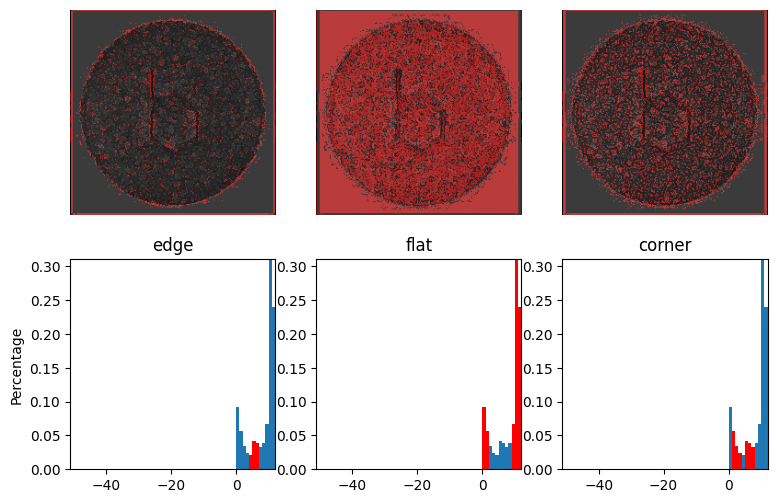

In [ ]:
radius = 2
n_points = 10
radius= 2
bin = 2**n_points
# n_points = 10 * radius

METHOD = 'uniform'
lbp = local_binary_pattern(sample_image, n_points, radius, METHOD)


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=np.arange(0, bin))


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(sample_image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

In [ ]:
lbp_extractor(sample_image).shape

(1023,)

In [ ]:
hog_extractor(sample_image)

array([0.70710678, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

In [ ]:
hog_extractor(sample_image)[0].shape

(26244,)

(array([1.0739e+04, 8.9170e+03, 6.0100e+03, 3.2800e+02, 9.3000e+01,
        3.7000e+01, 2.8000e+01, 8.4000e+01, 0.0000e+00, 8.0000e+00]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
 <BarContainer object of 10 artists>)

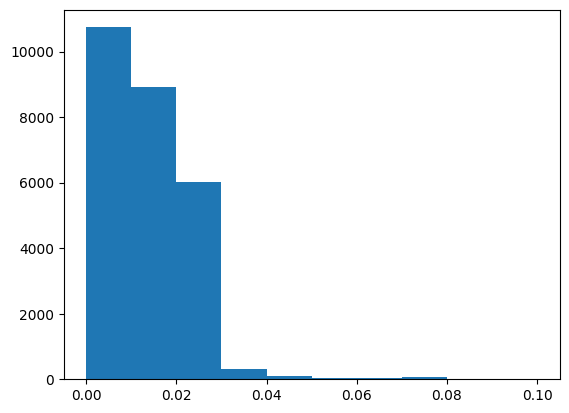

In [ ]:
plt.hist(hog_extractor(sample_image)[0])

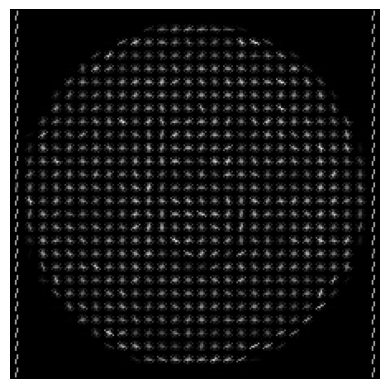

In [ ]:
plt.axis("off")
plt.imshow(hog_extractor(sample_image)[1], cmap="gray")

In [ ]:
# https://stackoverflow.com/questions/41457140/merge-lbp-and-hog-feature-descriptors?rq=4
np.hstack([lbp_extractor(sample_image), hog_extractor(sample_image)[0]])

array([4601., 2876., 1737., ...,    0.,    0.,    0.])

In [ ]:
np.hstack([lbp_extractor(sample_image), hog_extractor(sample_image)[0]]).shape

(27267,)

In [ ]:
class TextureDescriptor(object):
  """
  Preproccesses original dataset of images and extracts feature vectors for texture
  """

  def __init__(self, target_size=224):

    # Initialise and assign variables
    self.target_size = target_size

  def get_combined_features(self, img):
    try:
      # Preprocess image
      pp_img = self.preprocess_image(img)

      # Get feature vector from lbp_extractor
      lbp_features = self.lbp_extractor(pp_img)
      # Get feature vector from hog_extractor
      hog_features = self.hog_extractor(pp_img)

      return np.hstack([lbp_features, hog_features])

    except Exception as e:
      print("[Feature combination] Error occured:\n", e)


  def resize_img(self, img):
    """
    Resize image to target size
    """
    try:
      # https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
      # (h, w) of original image
      og_size = img.shape[:2]
      # Find ratio to prevent distortion
      ratio = float(self.target_size)/max(og_size)
      # Ratio-ed (h, w) of desired size
      new_size = tuple([int(x*ratio) for x in og_size])
      # (w, h) of target resized image
      img = cv2.resize(img, (new_size[1], new_size[0]))
      # Find differences of desired size (512) and newly computed size
      delta_w = self.target_size - new_size[1]
      delta_h = self.target_size - new_size[0]
      # Compute values for image padding to make black borders
      top, bottom = delta_h//2, delta_h-(delta_h//2)
      left, right = delta_w//2, delta_w-(delta_w//2)
      # Generate final binary image according to target size
      final_img = cv2.copyMakeBorder(img, top, bottom, left, right,
                                    cv2.BORDER_CONSTANT,
                                    value=[0, 0, 0])

      return final_img

    except Exception as e:
      print("[Image resizing] Error occured:\n", e)

  def lbp_extractor(self, img):
    # Define values for lbp
    radius= 2
    num_pts = 10
    bin = 2**num_pts

    # Compute lbp
    lbp = local_binary_pattern(img, num_pts, radius, method='uniform')
    # Compute lbp histograms by bins
    (hist, hist_len) = np.histogram(lbp.ravel(), bins=np.arange(0, bin))
    lbp_hist = hist.astype("float32")

    # flatten array
    # lbp_hist = np.array(lbp_hist).flatten()

    return np.array(lbp_hist, np.float32)

  def hog_extractor(self, img):
    fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2),
                        visualize=True, channel_axis=None)

    # Rescale histogram for better display
    fd = exposure.rescale_intensity(fd, in_range=(0, 10))

    return np.array(fd, np.float32)

  def preprocess_image(self, img):
    """
    Image preprocessing before foreground segmentation
    """
    try:
      # Make sure all images have the same size
      img = self.resize_img(img)

      # Convert image to greyscale
      grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      # Apply gaussian filter
      gaussian = cv2.GaussianBlur(grey_img, (3, 3) ,cv2.BORDER_DEFAULT)

      return grey_img

    except Exception as e:
      print("[Image Preprocessing] Error occured:\n", e)

In [ ]:
def texture_preprocessing_pipeline(image_paths,
                                   image_size=IMG_SIZE):

  #Instantiate class instance
  texture_extractor = TextureDescriptor(target_size=image_size)

  # Store preprocessed data
  X = []

  # Apply functions on each image and assign respective labels
  for image_path in tqdm(image_paths):
    # Read image
    input_img = cv2.imread(image_path)
    # Get feature vector
    features = texture_extractor.get_combined_features(input_img)

    # Append data to respective lists
    X.append(features)

  # Return preprocessed set of data
  return np.array(X)

In [ ]:
# Preprocess train and val sets
X_train_texture = texture_preprocessing_pipeline(image_paths=np.asarray(train_df['original_filepath'].values))
X_val_texture = texture_preprocessing_pipeline(image_paths=np.asarray(val_df['original_filepath'].values))

400it [05:40,  1.18it/s]
100it [01:24,  1.18it/s]


In [ ]:
len(X_train_texture)

400

In [ ]:
len(X_val_texture)

100

In [ ]:
create_folder(TEXTURE_DIR)

In [ ]:
# Save to .npz for re-usage
np.savez(os.path.join(TEXTURE_DIR, 'Train_texture.npz'), original_filepath=X_train, colour_filepath=np.array(train_df['colour_filepath']), feature=X_train_texture)
np.savez(os.path.join(TEXTURE_DIR, 'Val_texture.npz'), original_filepath=X_val, colour_filepath=val_df['colour_filepath'], feature=X_val_texture)

In [ ]:
train_texture_data = np.load(os.path.join(TEXTURE_DIR, 'Train_texture.npz'), allow_pickle=True)
val_texture_data = np.load(os.path.join(TEXTURE_DIR, 'Val_texture.npz'), allow_pickle=True)
print(len(train_texture_data))
print(len(val_texture_data))

4
4
